In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

2025-10-17 19:18:08.014766: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
dataset = pd.read_csv('datasets/cleaned/merged_fx_dataset.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4217 entries, 0 to 4216
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              4217 non-null   object 
 1   Buying            4217 non-null   float64
 2   Selling           4217 non-null   float64
 3   MidRate           4217 non-null   float64
 4   MPR               4217 non-null   float64
 5   GhInflationRate   4217 non-null   float64
 6   BrentOil          4217 non-null   float64
 7   Cocoa             4217 non-null   float64
 8   Gold              4217 non-null   float64
 9   GhInterestRate    4217 non-null   float64
 10  NetForeignAssets  4217 non-null   float64
 11  NIR               4217 non-null   float64
 12  Imports           4217 non-null   float64
 13  Exports           4217 non-null   float64
 14  GhGDP             4217 non-null   float64
 15  USGDP             4217 non-null   float64
 16  USInflationRate   4217 non-null   float64


In [4]:
dataset['Date'] = pd.to_datetime(dataset['Date'])

In [5]:
dataset.head()

,Date,Buying,Selling,MidRate,MPR,GhInflationRate,BrentOil,Cocoa,Gold,GhInterestRate,NetForeignAssets,NIR,Imports,Exports,GhGDP,USGDP,USInflationRate,USInterestRate
0,2024-12-31,14.6927,14.7074,14.70,27.0,23.82,73.18,10869.14,2641.45,27.03,3815.3387,6376.097,1266.31,1581.28,53957.1,23542.349,123.98,4.33
1,2024-12-30,14.7026,14.7174,14.71,27.0,23.82,73.18,10869.14,2641.45,27.03,3815.3387,6376.097,1266.31,1581.28,53957.1,23542.349,123.98,4.33
2,2024-12-27,14.6927,14.7074,14.70,27.0,23.82,73.18,10869.14,2641.45,27.03,3815.3387,6376.097,1266.31,1581.28,53957.1,23542.349,123.98,4.33
3,2024-12-24,14.6427,14.6573,14.65,27.0,23.82,73.18,10869.14,2641.45,27.03,3815.3387,6376.097,1266.31,1581.28,53957.1,23542.349,123.98,4.33
4,2024-12-23,14.6427,14.6573,14.65,27.0,23.82,73.18,10869.14,2641.45,27.03,3815.3387,6376.097,1266.31,1581.28,53957.1,23542.349,123.98,4.33


In [6]:
dataset = dataset.sort_values('Date').reset_index(drop=True)

In [7]:
dataset.head()

,Date,Buying,Selling,MidRate,MPR,GhInflationRate,BrentOil,Cocoa,Gold,GhInterestRate,NetForeignAssets,NIR,Imports,Exports,GhGDP,USGDP,USInflationRate,USInterestRate
0,2008-01-02,0.9545,0.9799,0.9672,13.5,12.81,91.9,2174.5,891.0,12.175,1979.35,1674.3,781.9,406.1,18863.43405,16843.003,87.093,4.11
1,2008-01-03,0.9545,0.9799,0.9672,13.5,12.81,91.9,2174.5,891.0,12.175,1979.35,1674.3,781.9,406.1,18863.43405,16843.003,87.093,4.25
2,2008-01-04,0.9543,0.9798,0.9671,13.5,12.81,91.9,2174.5,891.0,12.175,1979.35,1674.3,781.9,406.1,18863.43405,16843.003,87.093,4.18
3,2008-01-07,0.9551,0.9809,0.9680,13.5,12.81,91.9,2174.5,891.0,12.175,1979.35,1674.3,781.9,406.1,18863.43405,16843.003,87.093,4.27
4,2008-01-08,0.9576,0.9800,0.9688,13.5,12.81,91.9,2174.5,891.0,12.175,1979.35,1674.3,781.9,406.1,18863.43405,16843.003,87.093,4.27


In [28]:
dataset['Selling'] = pd.to_numeric(dataset['Selling'], errors='coerce')
dataset['Mid Rate'] = pd.to_numeric(dataset['Mid Rate'], errors='coerce')

In [30]:
columns = {'Buying': 'Buying', 'GDP': 'GDP', 'Interbank weighted average rate': 'InterestRate',
                'Monetary policy rate': 'MPR', 'Oil_Price': 'OilPrice', 'Cocoa_Price': 'CocoaPrice',
                'Gold_Price': 'GoldPrice', 'Headline Inflation': 'Inflation'}

for column in columns.items():
    dataset.rename(columns={column[0]: column[1]}, inplace=True)

In [10]:
dataset = dataset.drop(columns=['GhGDP', 'USGDP'])

In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4217 entries, 0 to 4216
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              4217 non-null   datetime64[ns]
 1   Buying            4217 non-null   float64       
 2   Selling           4217 non-null   float64       
 3   MidRate           4217 non-null   float64       
 4   MPR               4217 non-null   float64       
 5   GhInflationRate   4217 non-null   float64       
 6   BrentOil          4217 non-null   float64       
 7   Cocoa             4217 non-null   float64       
 8   Gold              4217 non-null   float64       
 9   GhInterestRate    4217 non-null   float64       
 10  NetForeignAssets  4217 non-null   float64       
 11  NIR               4217 non-null   float64       
 12  Imports           4217 non-null   float64       
 13  Exports           4217 non-null   float64       
 14  USInflationRate   4217 n

In [ ]:
lag_features = [
    'Buying',
    'GhInterestRate',
    'MPR',
    'BrentOil',
    'Cocoa',
    'Gold',
    'NIR',
    'CocoaPrice',
    'GoldPrice',
    'GhInflationRate',
    'USInflationRate',
    'USInterestRate',
    'Imports',
    'Exports',
    'NetForeignAssets'
]

In [36]:
for feature in lag_features:
    dataset[f'{feature}_lag1'] = dataset[feature].shift(1)
    dataset[f'{feature}_lag7'] = dataset[feature].shift(7)
    dataset[f'{feature}_lag30'] = dataset[feature].shift(30)
    dataset[f'{feature}_lag60'] = dataset[feature].shift(60)
    dataset[f'{feature}_lag90'] = dataset[feature].shift(90)
    dataset[f'{feature}_lag120'] = dataset[feature].shift(120)
    dataset[f'{feature}_chg'] = dataset[feature].pct_change()

In [38]:
dataset = dataset.dropna().reset_index(drop=True)

In [40]:
selected_features = [
    'GDP', 'InterestRate', 'MPR',
    'OilPrice', 'CocoaPrice', 'GoldPrice', 'Inflation',
    'Buying_lag1', 'Buying_lag7', 'Buying_lag30', 'Buying_lag60', 'Buying_lag90', 'Buying_lag120', 'Buying_chg',
    'OilPrice_chg', 'OilPrice_lag1', 'OilPrice_lag7', 'OilPrice_lag30', 'OilPrice_lag60', 'OilPrice_lag90', 'OilPrice_lag120',
    'CocoaPrice_chg', 'CocoaPrice_lag1', 'CocoaPrice_lag7', 'CocoaPrice_lag30', 'CocoaPrice_lag60', 'CocoaPrice_lag90', 'CocoaPrice_lag120',
    'GoldPrice_chg', 'GoldPrice_lag1', 'GoldPrice_lag7', 'GoldPrice_lag30', 'GoldPrice_lag60', 'GoldPrice_lag90', 'GoldPrice_lag120',
    'Inflation_chg', 'Inflation_lag1', 'Inflation_lag7', 'Inflation_lag30', 'Inflation_lag60', 'Inflation_lag90', 'Inflation_lag120',
]

In [41]:
target = 'Buying'

In [48]:
# Replace NaN and infinity values with 0 (or another value)
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
dataset.fillna(0, inplace=True)

In [49]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset[selected_features + [target]])
scaled_df = pd.DataFrame(scaled_data, columns=selected_features + [target])

In [52]:
lookback = 120
x, y = [], []

for i in range(lookback, len(scaled_df)):
    x.append(scaled_df[selected_features].iloc[i - lookback:i].values)
    y.append(scaled_df[target].iloc[i])

x, y = np.array(x), np.array(y)

x.shape, y.shape

((3708, 120, 42), (3708,))

In [53]:
split = int(0.8 * len(x))
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

In [57]:
dataset.set_index('Date', inplace=True)

In [59]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(
        x_train.shape[1], x_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

/Users/dela/Developer/thesis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 120, 128)       │        87,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,073 (543.25 KB)

 Trainable params: 139,073 (543.25 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 0.0063 - val_loss: 0.0050
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - loss: 0.0010 - val_loss: 0.0037
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 7.3986e-04 - val_loss: 0.0061
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 6.2527e-04 - val_loss: 5.7173e-04
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - loss: 5.5276e-04 - val_loss: 0.0023
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - loss: 4.8752e-04 - val_loss: 0.0043
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 3.6529e-04 - val_loss: 0.0042
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - loss: 3.8671e-04 - val_loss: 0.0022
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - loss: 3.2435e-04 - val_loss: 0.0041
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - loss: 2.8076e-04 - val_loss: 0.0047
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 2.9980e-04 - val_loss: 0.0035
Epoc

In [63]:
# Predictions
y_predictions = model.predict(x_test)

# Inverse scaling (to original range)
scaler_target = MinMaxScaler()
scaler_target.fit(dataset[[target]])
y_test_inverse = scaler_target.inverse_transform(y_test.reshape(-1, 1))
y_pred_inverse = scaler_target.inverse_transform(y_predictions)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


In [65]:
# Metrics
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"MSE: {mse:.6f}")
print(f"R²:  {r2:.4f}")

MSE: 9.033741
R²:  -0.4818


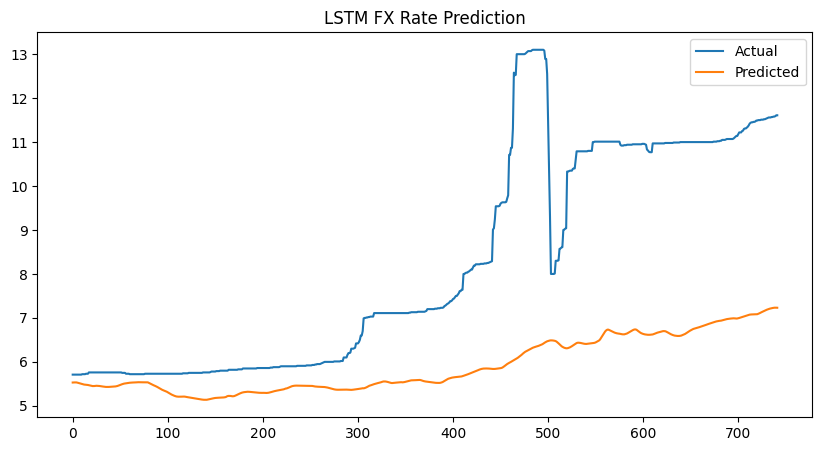

In [66]:
# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test_inverse, label='Actual')
plt.plot(y_pred_inverse, label='Predicted')
plt.title("LSTM FX Rate Prediction")
plt.legend()
plt.show()

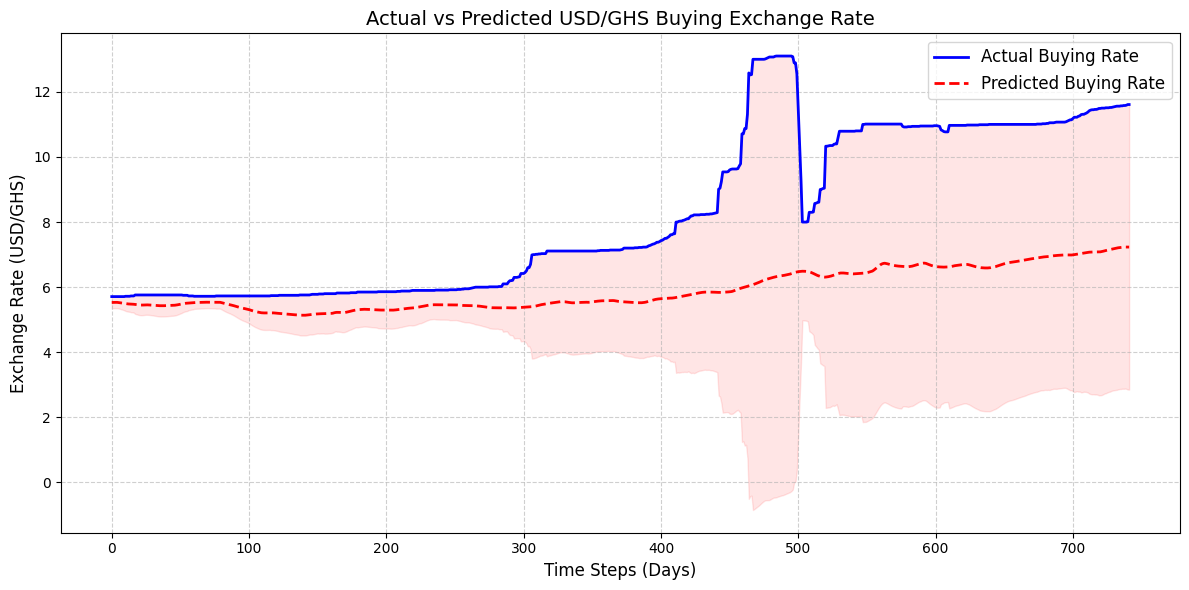

In [67]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Buying Rate', color='blue', linewidth=2)
plt.plot(y_pred_inverse, label='Predicted Buying Rate',
         color='red', linestyle='--', linewidth=2)

# Add grid, labels, and styling
plt.title("Actual vs Predicted USD/GHS Buying Exchange Rate", fontsize=14)
plt.xlabel("Time Steps (Days)", fontsize=12)
plt.ylabel("Exchange Rate (USD/GHS)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Add shaded error area (optional)
error = np.abs(y_pred_inverse - y_test_inverse)
plt.fill_between(range(len(y_test_inverse)),
                 (y_pred_inverse - error).flatten(),
                 (y_pred_inverse + error).flatten(),
                 color='red', alpha=0.1, label='Prediction Error Margin')

plt.tight_layout()
plt.show()

In [74]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

In [75]:
def build_model(hp):
    model = Sequential()

    # First LSTM layer
    model.add(LSTM(
        units=hp.Int('lstm_units_1', min_value=64, max_value=256, step=32),
        return_sequences=True,
        input_shape=(x_train.shape[1], x_train.shape[2])
    ))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.4, step=0.1)))

    # Optional second LSTM layer
    model.add(LSTM(
        units=hp.Int('lstm_units_2', min_value=32, max_value=128, step=32),
        return_sequences=False
    ))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.4, step=0.1)))

    # Dense layer
    model.add(Dense(
        units=hp.Int('dense_units', min_value=16, max_value=64, step=16),
        activation='relu'
    ))

    # Output layer
    model.add(Dense(1))

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice(
            'learning_rate', [1e-3, 5e-4, 1e-4])),
        loss='mse'
    )

    return model

In [76]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=15,  # number of different model configurations to test
    executions_per_trial=1,
    directory='tuner_results',
    project_name='lstm_fx_prediction'
)

In [77]:
early_stop = EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=True)

tuner.search(
    x_train, y_train,
    epochs=50,
    validation_split=0.2,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Trial 10 Complete [00h 01m 19s]
val_loss: 0.006395354866981506

Best val_loss So Far: 0.0007781249587424099
Total elapsed time: 00h 25m 07s

Search: Running Trial #11

Value             |Best Value So Far |Hyperparameter
192               |160               |lstm_units_1
0.1               |0.4               |dropout_1
128               |64                |lstm_units_2
0.3               |0.2               |dropout_2
48                |16                |dense_units
0.001             |0.0001            |learning_rate

Epoch 1/50
46/75 ━━━━━━━━━━━━━━━━━━━━ 7s 265ms/step - loss: 0.0285

KeyboardInterrupt: 

In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for key, value in best_hp.values.items():
    print(f"  {key}: {value}")

best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate on test set
y_pred_tuned = best_model.predict(X_test)

# Inverse scale predictions
y_test_inv = scaler.inverse_transform(np.concatenate([np.zeros(
    (len(y_test), len(selected_features))), y_test.reshape(-1, 1)], axis=1))[:, -1]
y_pred_inv = scaler.inverse_transform(np.concatenate([np.zeros(
    (len(y_pred_tuned), len(selected_features))), y_pred_tuned], axis=1))[:, -1]

mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"\nTuned Model MSE: {mse:.6f}")
print(f"Tuned Model R²: {r2:.4f}")

# v2

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [28]:
fx_data = pd.read_csv('datasets/cleaned/merged_fx_dataset.csv')

In [29]:
fx_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4217 entries, 0 to 4216
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              4217 non-null   object 
 1   Buying            4217 non-null   float64
 2   Selling           4217 non-null   float64
 3   MidRate           4217 non-null   float64
 4   MPR               4217 non-null   float64
 5   GhInflationRate   4217 non-null   float64
 6   BrentOil          4217 non-null   float64
 7   Cocoa             4217 non-null   float64
 8   Gold              4217 non-null   float64
 9   GhInterestRate    4217 non-null   float64
 10  NetForeignAssets  4217 non-null   float64
 11  NIR               4217 non-null   float64
 12  Imports           4217 non-null   float64
 13  Exports           4217 non-null   float64
 14  GhGDP             4217 non-null   float64
 15  USGDP             4217 non-null   float64
 16  USInflationRate   4217 non-null   float64


In [30]:
fx_data['Date'] = pd.to_datetime(fx_data['Date'])

In [31]:
fx_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4217 entries, 0 to 4216
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              4217 non-null   datetime64[ns]
 1   Buying            4217 non-null   float64       
 2   Selling           4217 non-null   float64       
 3   MidRate           4217 non-null   float64       
 4   MPR               4217 non-null   float64       
 5   GhInflationRate   4217 non-null   float64       
 6   BrentOil          4217 non-null   float64       
 7   Cocoa             4217 non-null   float64       
 8   Gold              4217 non-null   float64       
 9   GhInterestRate    4217 non-null   float64       
 10  NetForeignAssets  4217 non-null   float64       
 11  NIR               4217 non-null   float64       
 12  Imports           4217 non-null   float64       
 13  Exports           4217 non-null   float64       
 14  GhGDP             4217 n

In [32]:
fx_data = fx_data.copy().drop(columns=['Selling', 'MidRate'])

In [33]:
fx_data.columns

Index(['Date', 'Buying', 'MPR', 'GhInflationRate', 'BrentOil', 'Cocoa', 'Gold',
       'GhInterestRate', 'NetForeignAssets', 'NIR', 'Imports', 'Exports',
       'GhGDP', 'USGDP', 'USInflationRate', 'USInterestRate'],
      dtype='object')

In [34]:
fx_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,4217,2016-06-29 13:36:07.512449280,2008-01-02 00:00:00,2012-03-27 00:00:00,2016-06-29 00:00:00,2020-09-30 00:00:00,2024-12-31 00:00:00,NaN
Buying,4217.0,4.625836,0.0,1.7005,3.9443,5.6998,16.4118,3.591187
MPR,4217.0,18.941902,12.5,15.0,17.0,22.0,30.0,5.200142
GhInflationRate,4217.0,15.501468,4.67,9.02,12.78,18.31,54.1,9.615771
BrentOil,4217.0,78.60924,26.6257,59.4745,75.7,103.3,134.8,24.506153
Cocoa,4217.0,3142.189529,1904.6,2365.7727,2622.3,3010.1,40370.0,3009.582545
Gold,4217.0,1471.200405,760.8,1220.8077,1339.2,1746.9,2689.38,387.07452
GhInterestRate,4217.0,18.892103,6.35,13.8225,17.5,24.135,30.19,5.561471
NetForeignAssets,4217.0,2337.4978,-2167.127029,1675.4,2490.2,3453.106326,5521.651498,1524.44229
NIR,4217.0,3491.215451,674.6,2350.9,3205.3,4439.0,8231.125878,1632.947615


In [35]:
fx_data['Buying'] = fx_data['Buying'].replace(0, np.nan)
fx_data['Buying'] = fx_data['Buying'].interpolate()

In [36]:
fx_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,4217,2016-06-29 13:36:07.512449280,2008-01-02 00:00:00,2012-03-27 00:00:00,2016-06-29 00:00:00,2020-09-30 00:00:00,2024-12-31 00:00:00,NaN
Buying,4217.0,4.628673,0.9543,1.7037,3.9443,5.6998,16.4118,3.588095
MPR,4217.0,18.941902,12.5,15.0,17.0,22.0,30.0,5.200142
GhInflationRate,4217.0,15.501468,4.67,9.02,12.78,18.31,54.1,9.615771
BrentOil,4217.0,78.60924,26.6257,59.4745,75.7,103.3,134.8,24.506153
Cocoa,4217.0,3142.189529,1904.6,2365.7727,2622.3,3010.1,40370.0,3009.582545
Gold,4217.0,1471.200405,760.8,1220.8077,1339.2,1746.9,2689.38,387.07452
GhInterestRate,4217.0,18.892103,6.35,13.8225,17.5,24.135,30.19,5.561471
NetForeignAssets,4217.0,2337.4978,-2167.127029,1675.4,2490.2,3453.106326,5521.651498,1524.44229
NIR,4217.0,3491.215451,674.6,2350.9,3205.3,4439.0,8231.125878,1632.947615


In [38]:
correlation_matrix = fx_data.drop(columns=['Date']).corr()
correlation_matrix

,Buying,MPR,GhInflationRate,BrentOil,Cocoa,Gold,GhInterestRate,NetForeignAssets,NIR,Imports,Exports,GhGDP,USGDP,USInflationRate,USInterestRate
Buying,1.000000,0.682408,0.593450,-0.161048,0.405183,0.786898,0.557237,-0.383589,0.332597,0.182203,0.705949,0.856077,0.920281,0.963488,0.805792
MPR,0.682408,1.000000,0.721012,-0.306968,0.354091,0.273834,0.929210,-0.556938,-0.252147,-0.010737,0.287898,0.455227,0.541088,0.590186,0.652009
GhInflationRate,0.593450,0.721012,1.000000,-0.004167,0.191006,0.283661,0.632274,-0.860431,-0.327804,-0.117714,0.170623,0.339792,0.444846,0.539818,0.602376
BrentOil,-0.161048,-0.306968,-0.004167,1.000000,0.026612,0.131911,-0.305075,-0.156607,-0.203778,0.454536,0.088995,-0.224610,-0.216868,-0.149119,0.033213
Cocoa,0.405183,0.354091,0.191006,0.026612,1.000000,0.334001,0.323933,-0.168803,-0.018178,0.144969,0.245669,0.261599,0.289083,0.340774,0.408482
Gold,0.786898,0.273834,0.283661,0.131911,0.334001,1.000000,0.145015,-0.123699,0.538066,0.496034,0.772752,0.745739,0.740478,0.807213,0.499376
GhInterestRate,0.557237,0.929210,0.632274,-0.305075,0.323933,0.145015,1.000000,-0.521751,-0.345981,-0.037858,0.176501,0.340562,0.403216,0.453458,0.509097
NetForeignAssets,-0.383589,-0.556938,-0.860431,-0.156607,-0.168803,-0.123699,-0.521751,1.000000,0.559639,0.071854,-0.036786,-0.168958,-0.269320,-0.358397,-0.438224
NIR,0.332597,-0.252147,-0.327804,-0.203778,-0.018178,0.538066,-0.345981,0.559639,1.000000,0.211136,0.542305,0.570427,0.517540,0.451038,-0.005623
Imports,0.182203,-0.010737,-0.117714,0.454536,0.144969,0.496034,-0.037858,0.071854,0.211136,1.000000,0.552714,0.308943,0.224671,0.250407,0.055925


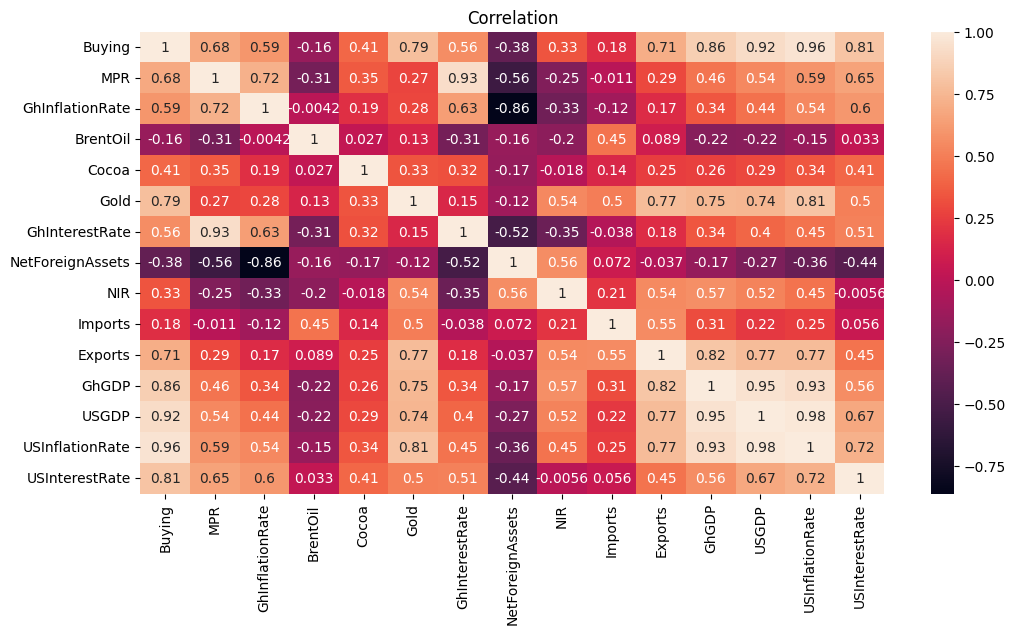

In [39]:
plt.figure(figsize=(12, 6))
# sns.heatmap(correlation_matrix, annot=True, cmap='rocket_r')
# sns.heatmap(correlation_matrix, annot=True, cmap='rocket')
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation')
plt.show()